<a href="https://colab.research.google.com/github/KrishnaSChavan/MachineLearning/blob/main/Transfer_learning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifiying multiple images with transfer learning

### Feature extraction

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_r = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_r.extractall()
zip_r.close()

--2023-06-07 17:00:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.9MB/s    in 8.5s    

2023-06-07 17:00:54 (18.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential,layers
import pathlib


In [3]:
def loss_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs =  range(len(history.history['loss']))

    plt.plot(epochs,loss,label='loss')
    plt.plot(epochs,val_loss,label='val_loss')
    plt.title('loss')
    plt.legend()

    plt.figure()

    plt.plot(epochs,accuracy,label='accuracy')
    plt.plot(epochs,val_accuracy,label='val_accuracy')
    plt.title('accuracy')
    plt.legend()
     

In [4]:
def model_details(model = None):
    return tf.keras.utils.plot_model(model,to_file='model.png', show_shapes=True, show_dtype=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96, layer_range=None, show_layer_activations=True)

In [5]:
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"): 
  print(f"There are {dirnames} directories and {len(filenames)} images in '{dirpath}'.")

There are ['test', 'train'] directories and 0 images in '10_food_classes_10_percent'.
There are ['pizza', 'chicken_curry', 'steak', 'fried_rice', 'hamburger', 'ramen', 'chicken_wings', 'sushi', 'grilled_salmon', 'ice_cream'] directories and 0 images in '10_food_classes_10_percent/test'.
There are [] directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are [] directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are [] directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are [] directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are [] directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are [] directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are [] directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are [] directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are [] di

In [9]:
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'


train_datagen = ImageDataGenerator(rescale=(1/255.))
test_datagen = ImageDataGenerator(rescale=(1/255.))

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)
test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


CALLBACKS

tensorboard callback




In [10]:
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
    log_dir = dir_name+'/'+experiment_name+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"saving tensorboard file to {log_dir}")
    return tensorboard_callback

https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
effnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'



In [ ]:
# def create_model(model_url,num_classes=10):

#     # download model
#     feature_extraction_layer = hub.KerasLayer(model_url,trainable=False,name="feature_extraction",input_shape=IMAGE_SHAPE+(3,))

#     # create our own model
#     model = Sequential({
#         feature_extraction_layer,
#         Dense(num_classes,activation='softmax',name='output')
#     })

#     return model

####

#Use models.add 


####


In [11]:
def create_model(model_url, num_classes=10):
    # download model
    feature_extraction_layer = hub.KerasLayer(model_url, trainable=False, name="feature_extraction", input_shape=IMAGE_SHAPE+(3,))
    
    # create our own model
    model = Sequential()
    model.add(feature_extraction_layer)
    model.add(Dense(num_classes, activation='softmax', name='output'))
    
    return model


In [12]:
# create Resnet model from tf_hub 

resnet_model = create_model(resnet_url)

In [13]:
def c(model_url,n_c=10):

    feature_extraction = hub.KerasLayer(model_url,trainable=False,name="feature",input_shape=IMAGE_SHAPE+(3,))

    model = Sequential([
        feature_extraction,
        Dense(n_c,activation='softmax',name='output_layer')
    ])

    return model

In [14]:
effnet_model = c(effnet_url)

In [11]:
effnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature (KerasLayer)        (None, 1280)              4049564   
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction (KerasLa  (None, 2048)             23564800  
 yer)                                                            
                                                                 
 output (Dense)              (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [22]:
# compile model

resnet_model.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(),
    metrics=['accuracy']
)

In [23]:
resnet_history=resnet_model.fit(
            train_data,
            epochs = 5,
            steps_per_epoch =len(train_data),
            validation_data=test_data,
            validation_steps=len(test_data),
            callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',experiment_name='resnet50 v2')]
)

saving tensorboard file to tensorflow_hub/resnet50 v220230607-170841
Epoch 1/5
24/24 [==============================] - 36s 950ms/step - loss: 1.8389 - accuracy: 0.3773 - val_loss: 1.1404 - val_accuracy: 0.6320
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.8877 - accuracy: 0.7320 - val_loss: 0.8077 - val_accuracy: 0.7460
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.6100 - accuracy: 0.8213 - val_loss: 0.7210 - val_accuracy: 0.7668
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.4617 - accuracy: 0.8893 - val_loss: 0.6800 - val_accuracy: 0.7792
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.3682 - accuracy: 0.9187 - val_loss: 0.6555 - val_accuracy: 0.7872


<Axes: >

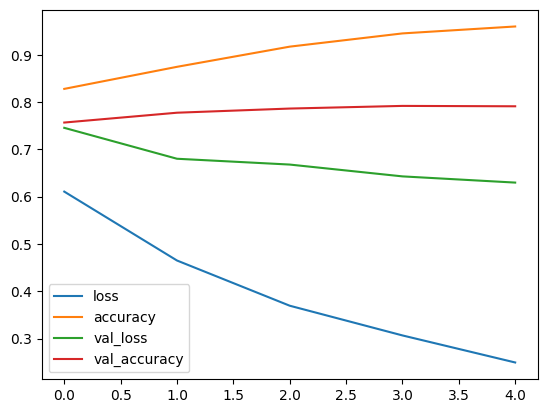

In [16]:
pd.DataFrame(resnet_history.history).plot()

In [24]:
effnet_model.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(),
    metrics = ['accuracy']
)

In [25]:
effnet_history = effnet_model.fit(
    train_data,
    epochs = 5,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps=len(test_data),
    callbacks =[
        create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name='effnet')
    ]
)

saving tensorboard file to tensorflow_hub/effnet20230607-171122
Epoch 1/5
24/24 [==============================] - 31s 896ms/step - loss: 1.8827 - accuracy: 0.4053 - val_loss: 1.3036 - val_accuracy: 0.7312
Epoch 2/5
24/24 [==============================] - 18s 753ms/step - loss: 1.0650 - accuracy: 0.7547 - val_loss: 0.8670 - val_accuracy: 0.8168
Epoch 3/5
24/24 [==============================] - 18s 761ms/step - loss: 0.7574 - accuracy: 0.8413 - val_loss: 0.7007 - val_accuracy: 0.8408
Epoch 4/5
24/24 [==============================] - 19s 814ms/step - loss: 0.6091 - accuracy: 0.8827 - val_loss: 0.6084 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 18s 763ms/step - loss: 0.5127 - accuracy: 0.8867 - val_loss: 0.5581 - val_accuracy: 0.8616


<Axes: >

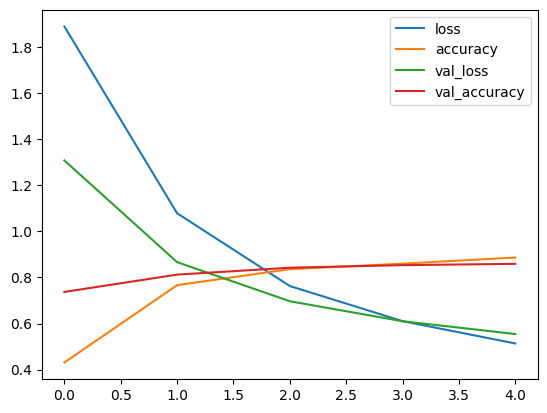

In [19]:
pd.DataFrame(effnet_history.history).plot()

In [ ]:
# resnet_history = resnet_model.fit(
#     train_data,
#     epochs = 5,
#     steps_per_epoch=len(train_data),
#     validation_data = test_data,
#     validation_steps=len(test_data),
#     callbacks=[
#         create_tensorboard_callback(dir_name='tensorflow_hub',
#                                     experiment_name='resnet50 v2')
#     ]
    
# )

saving tensorboard file to tensorflow_hub/resnet50 v220230602-183522
Epoch 1/5
24/24 [==============================] - 21s 821ms/step - loss: 0.3375 - accuracy: 0.9173 - val_loss: 0.6375 - val_accuracy: 0.7880
Epoch 2/5
24/24 [==============================] - 18s 756ms/step - loss: 0.2355 - accuracy: 0.9547 - val_loss: 0.6366 - val_accuracy: 0.7824
Epoch 3/5
24/24 [==============================] - 18s 782ms/step - loss: 0.1851 - accuracy: 0.9693 - val_loss: 0.6503 - val_accuracy: 0.7756
Epoch 4/5
24/24 [==============================] - 18s 755ms/step - loss: 0.1415 - accuracy: 0.9853 - val_loss: 0.6132 - val_accuracy: 0.7924
Epoch 5/5
24/24 [==============================] - 20s 856ms/step - loss: 0.1146 - accuracy: 0.9907 - val_loss: 0.6070 - val_accuracy: 0.7940


<Axes: >

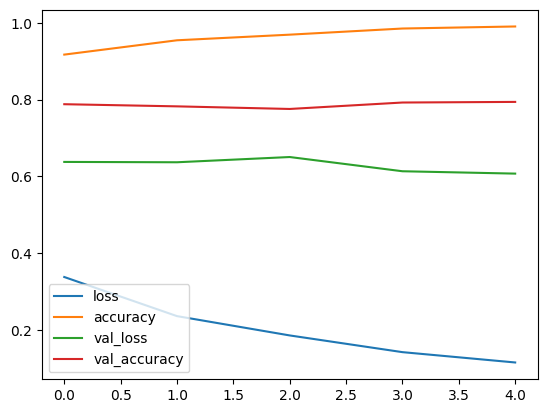

In [ ]:
pd.DataFrame(resnet_history.history).plot()

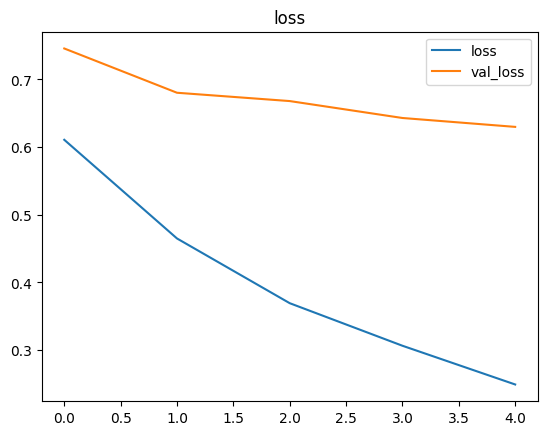

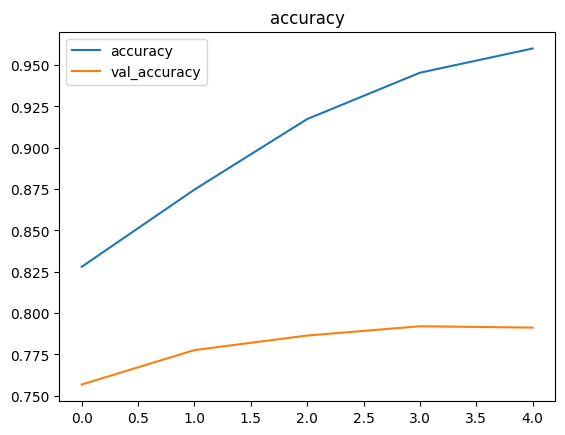

In [21]:
loss_curve(resnet_history)

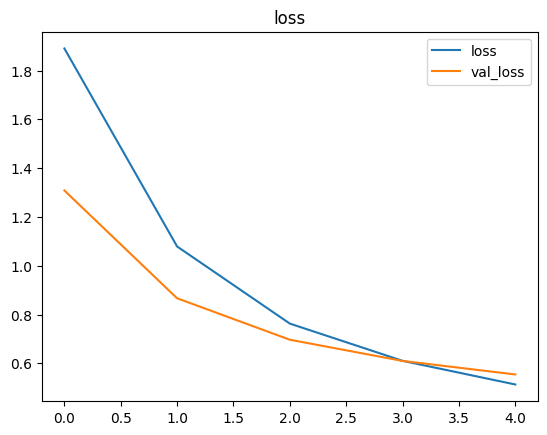

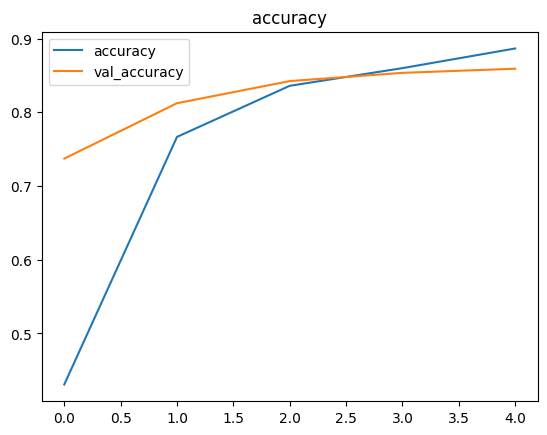

In [22]:
loss_curve(effnet_history)

In [ ]:
IMG_SHAPE = (224, 224, 3)
model0 = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
tf.keras.utils.plot_model(model0) # to draw and visualize
model0.summary() # to see the list of layers and parameters


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.975208 to fit



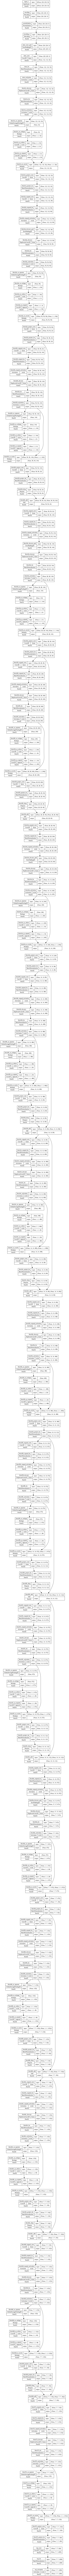

In [25]:
model_details(model0)

effnet_model.layers[0]

# Comparing model using tensorboard

Uploade to tensorboard.dev

In [ ]:
#@title
!tensorboard dev upload --logdir /content/tensorflow_hub/ \
--name "effnet vs resnet" \
--description "Compair" \
--one_shot

#### Link for tensorboard

[Tensorboard compair](https://tensorboard.dev/experiment/3X1ZLau5QCeR7tw2VCQ0Uw/)

In [29]:
!tensorboard dev list

2023-06-07 17:33:05.597684: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/3X1ZLau5QCeR7tw2VCQ0Uw/
	Name                 effnet vs resnet
	Description          Compair
	Id                   3X1ZLau5QCeR7tw2VCQ0Uw
	Created              2023-06-07 17:21:57 (11 minutes ago)
	Updated              2023-06-07 17:22:02 (11 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5779331
Total: 1 experiment(s)


#### To delete experiment from tensorboard we can simply use



```
!tensorboard dev delete --experiment_id 3X1ZLau5QCeR7tw2VCQ0Uw
```

